In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()
%config InlineBackend.figure_format='retina'

In [32]:
y_train, y_valid, y_test = pickle.load(open('../datasets/bm/labels.pkl', 'rb'))
project, group = 'bm_prolific_d512_e50', 'pre_no_aug_0'
results = pd.read_csv(f'results/MTL0_d50/{project}.{group}.csv')
id_columns = ['agent', 'name', 'model', 'seed']
ts_columns = ['test_clf_acc', 'test_1nn_acc', 'test_triplet_acc']
ds_columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
kd = [2, 3]
kd_columns = ['_'.join([str(k), ds]) for ds in ds_columns for k in kd]
er_columns = ['NINO_ds_err', 'NIFO_ds_err', 'rNINO_ds_err']
ni_columns = ['NIs', 'NI_acc', 'NO_acc']
all_columns = id_columns + ts_columns + ds_columns + kd_columns + ni_columns

In [33]:
df = results.copy()
df['perf'] = df['test_clf_acc'] + df['test_triplet_acc']
df = df.loc[df.groupby('model')['perf'].idxmax()]
best = {k:int(v) for k, v in zip(df['model'], df['seed'])}
agent = 's'.join(['MTL0', str(best['MTL0'])])
best, agent

({'MTL0': 4, 'MTL0.2': 4, 'MTL0.5': 0, 'MTL0.8': 4, 'MTL1': 4}, 'MTL0s4')

In [34]:
df = results.copy()
for k, v in best.items():
    df = df.drop(df[(df['model']==k) & ~(df['seed'] == v)].index)
df = df.drop(df[(df['agent']=='MTL0') & ~(df['seed'] == best['MTL0'])].index)
df_best = df.copy()
df_agent = results[results['agent'] == agent].copy()
df_agent_best = df_agent.loc[[
    i for i in df_best.index if i in df_agent.index]].copy()
df_agent_best[['name'] + ts_columns]

,name,test_clf_acc,test_1nn_acc,test_triplet_acc
104,MTL0s4,0.600,0.925,0.74750
109,MTL0.2s4,0.950,0.950,0.76125
110,MTL0.5s0,1.000,0.975,0.73250
119,MTL0.8s4,1.000,0.950,0.74125
124,MTL1s4,0.975,0.975,0.63125


In [35]:
def get_ci(samples, confidence=0.95):
    from scipy import stats
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
df_mean = results.groupby(['agent', 'model']).agg(
    {c: 'mean' for c in ds_columns}).reset_index()
df_sems = results.groupby(['agent', 'model']).agg(
    {c: get_ci for c in ds_columns}).reset_index()
def get_df_mean_sems(df_mean, df_sems, agent=None):
    if agent is not None:
        df_mean = df_mean[df_mean['agent'] == agent]
        df_sems = df_sems[df_sems['agent'] == agent]
    columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
    df_mean_sems = df_mean.copy()
    df_mean_sems[columns] = df_mean[columns].applymap("{:.3f} ± ".format)
    df_mean_sems[columns] += df_sems[columns].applymap("{:.3f}".format)
    return df_mean_sems
get_df_mean_sems(df_mean, df_sems).head()

,agent,model,NINO_ds_acc,NIFO_ds_acc,rNINO_ds_acc
0,MTL0s0,MTL0,0.870 ± 0.119,1.000 ± 0.000,0.870 ± 0.135
1,MTL0s0,MTL0.2,0.845 ± 0.188,1.000 ± 0.000,0.860 ± 0.162
2,MTL0s0,MTL0.5,0.855 ± 0.102,1.000 ± 0.000,0.865 ± 0.071
3,MTL0s0,MTL0.8,0.870 ± 0.111,1.000 ± 0.000,0.880 ± 0.119
4,MTL0s0,MTL1,0.865 ± 0.136,0.850 ± 0.248,0.855 ± 0.119


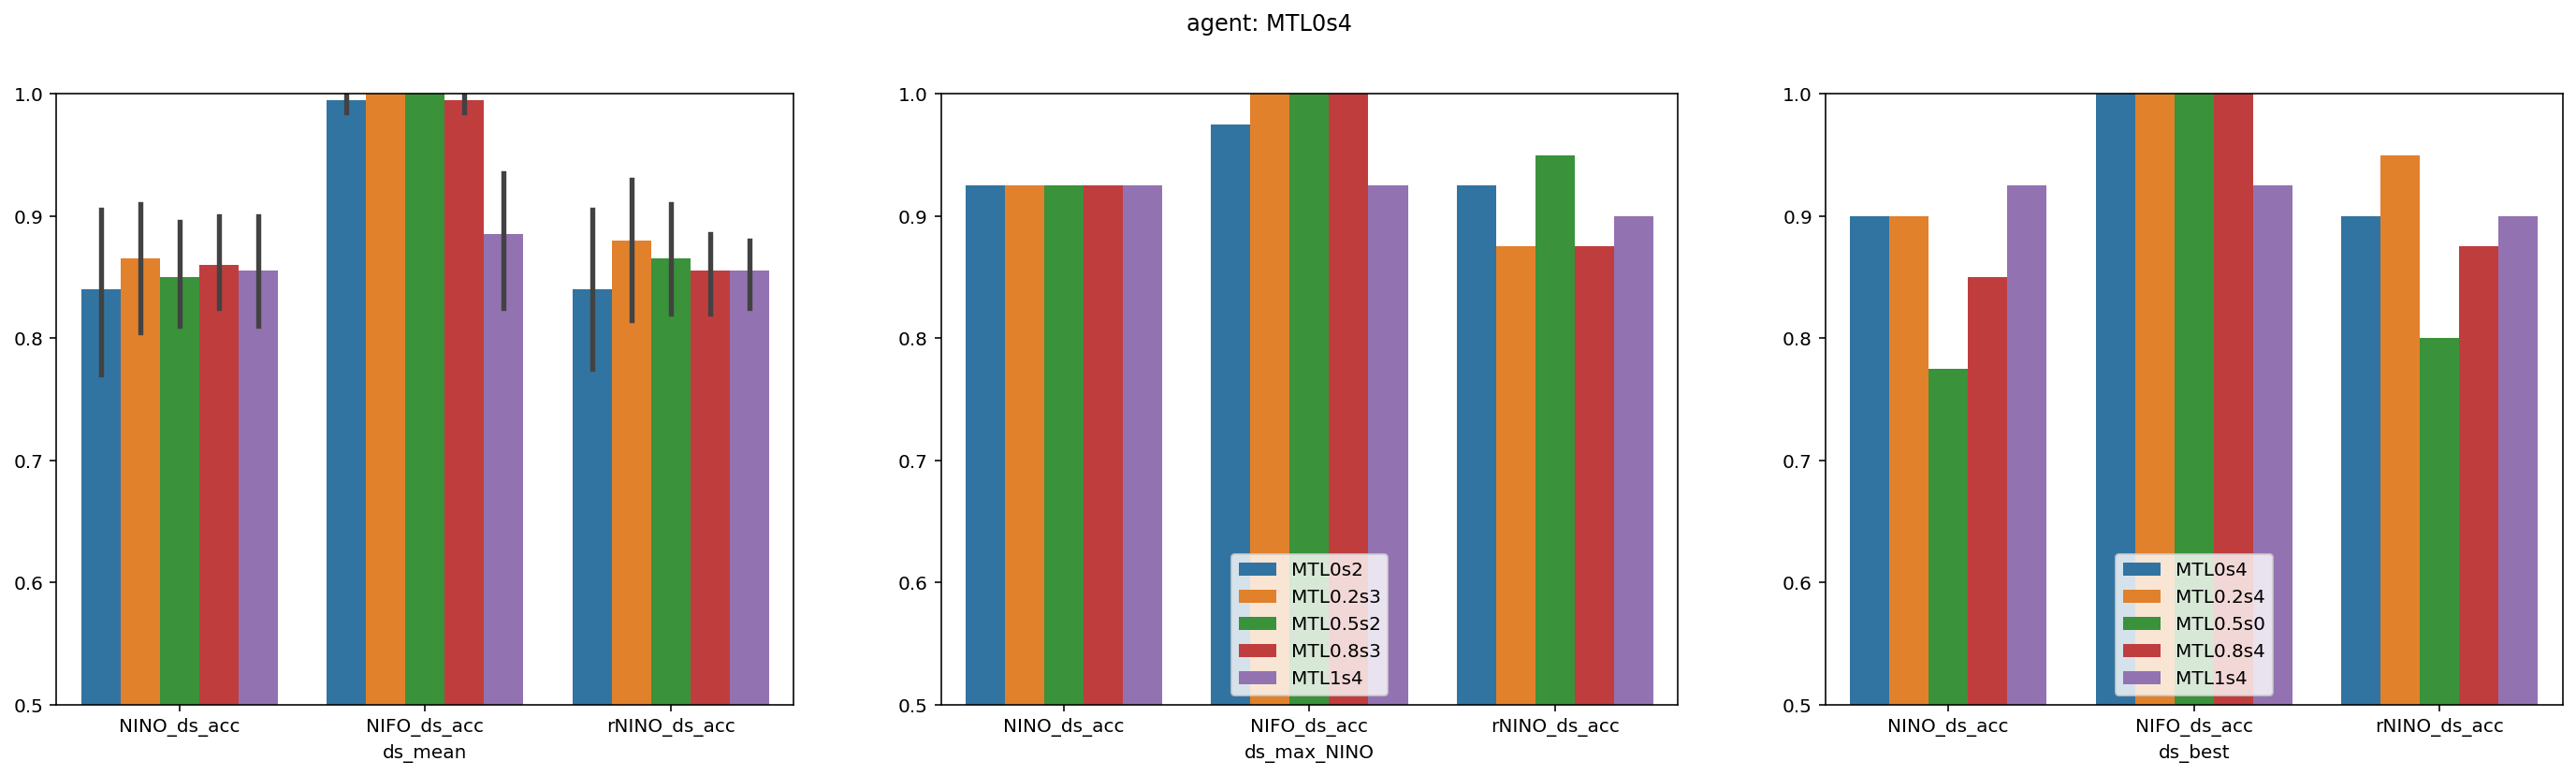

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
fig.suptitle(f"agent: {agent}"); ax[0].set_ylim((0.5, 1))
df_melt = pd.melt(df_agent, id_columns, ds_columns, var_name='ds_mean', value_name='acc')
sns.barplot(ax=ax[0], x='ds_mean', y='acc', hue='model', data=df_melt)
df = df_agent.loc[df_agent.groupby('model')['NINO_ds_acc'].idxmax()]
df_melt = pd.melt(df, id_columns, ds_columns, var_name='ds_max_NINO', value_name='acc')
sns.barplot(ax=ax[1], x='ds_max_NINO', y='acc', hue='name', data=df_melt)
df_melt = pd.melt(df_agent_best, id_columns, ds_columns, var_name='ds_best', value_name='acc')
sns.barplot(ax=ax[2], x='ds_best', y='acc', hue='name', data=df_melt)
_ = [(ax.set_ylim((0.5, 1)), ax.set(ylabel=None), ax.get_legend().remove()) for ax in ax]
ax[1].legend(loc='lower center')
ax[2].legend(loc='lower center')
fig.savefig(f'plots/MTL0_d50/{project}.{group}/1ds.pdf')

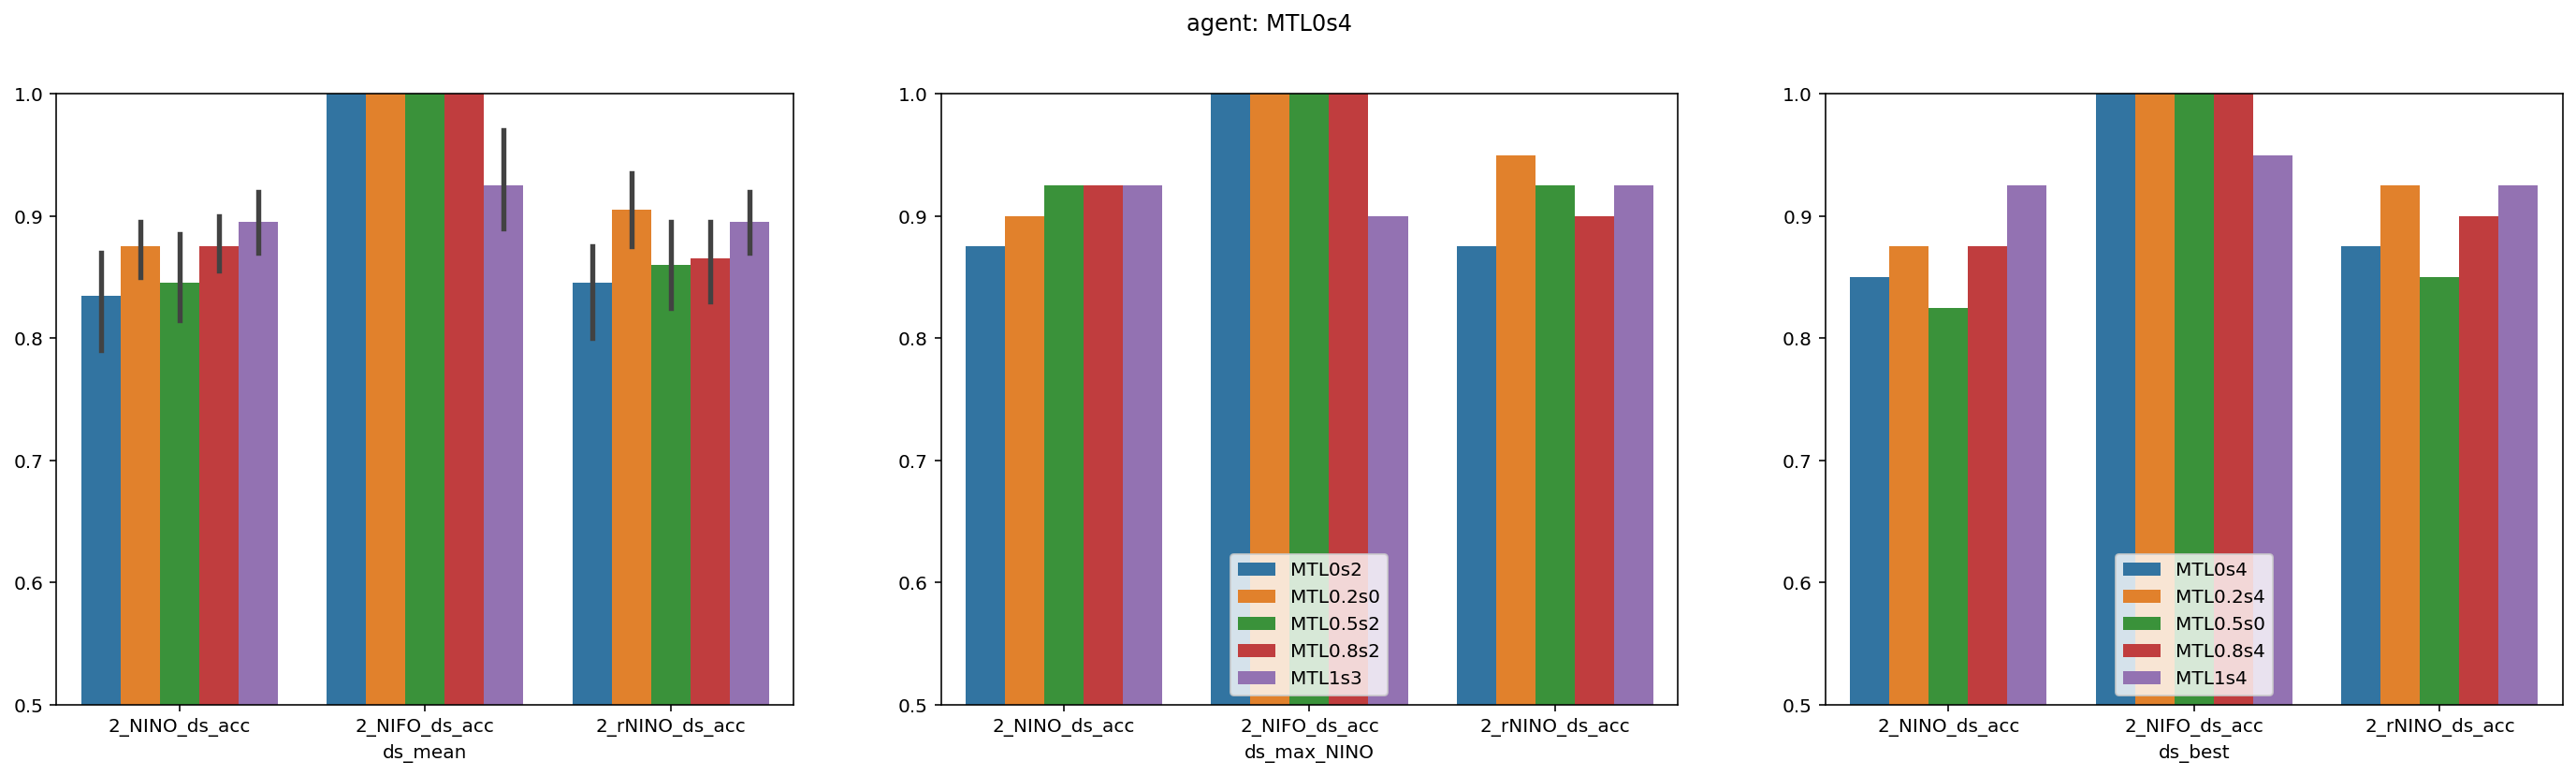

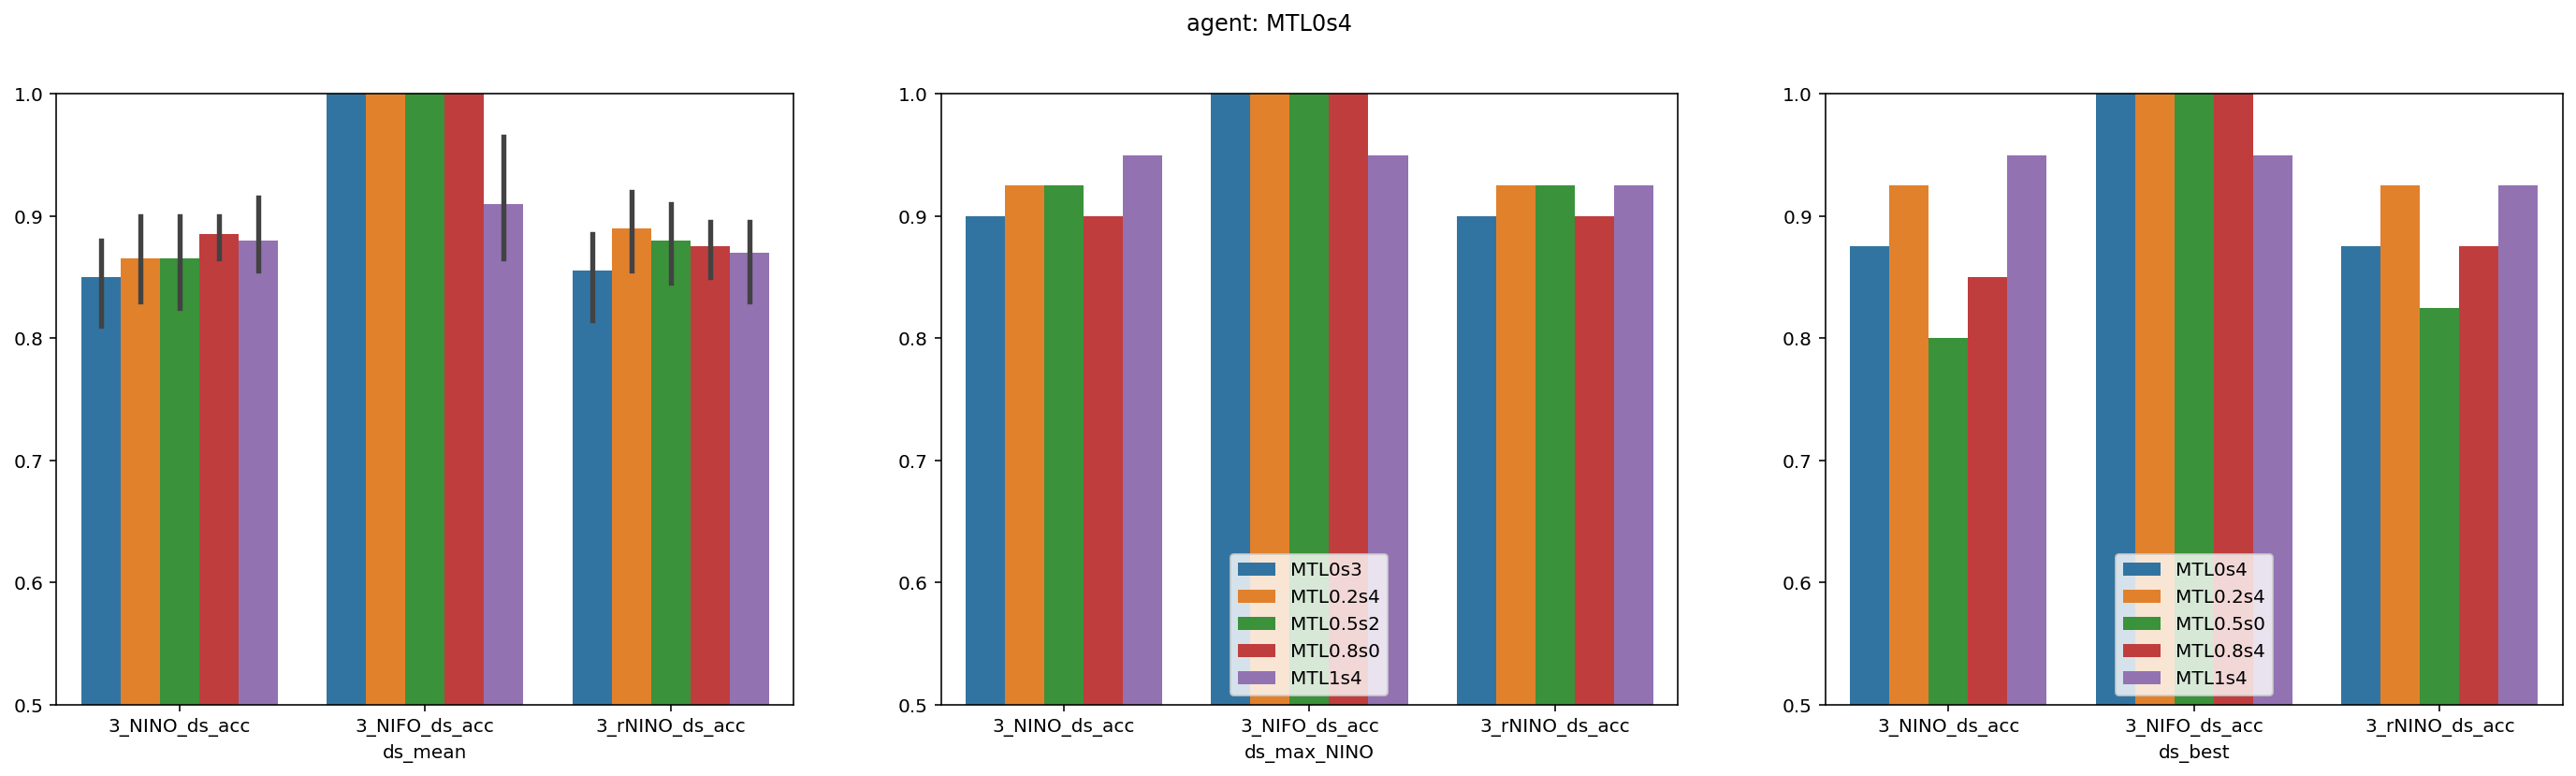

In [37]:
for k in kd:
    kd_column = [kdc for kdc in kd_columns if kdc[0] == str(k)]
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(f"agent: {agent}"); ax[0].set_ylim((0.5, 1))
    df_melt = pd.melt(df_agent, id_columns, kd_column, var_name='ds_mean', value_name='acc')
    sns.barplot(ax=ax[0], x='ds_mean', y='acc', hue='model', data=df_melt)
    df = df_agent.loc[df_agent.groupby('model')[str(k) + '_NINO_ds_acc'].idxmax()]
    df_melt = pd.melt(df, id_columns, kd_column, var_name='ds_max_NINO', value_name='acc')
    sns.barplot(ax=ax[1], x='ds_max_NINO', y='acc', hue='name', data=df_melt)
    df_melt = pd.melt(df_agent_best, id_columns, kd_column, var_name='ds_best', value_name='acc')
    sns.barplot(ax=ax[2], x='ds_best', y='acc', hue='name', data=df_melt)
    _ = [(ax.set_ylim((0.5, 1)), ax.set(ylabel=None), ax.get_legend().remove()) for ax in ax]
    ax[1].legend(loc='lower center')
    ax[2].legend(loc='lower center')
    fig.savefig(f'plots/MTL0_d50/{project}.{group}/{k}ds.pdf')

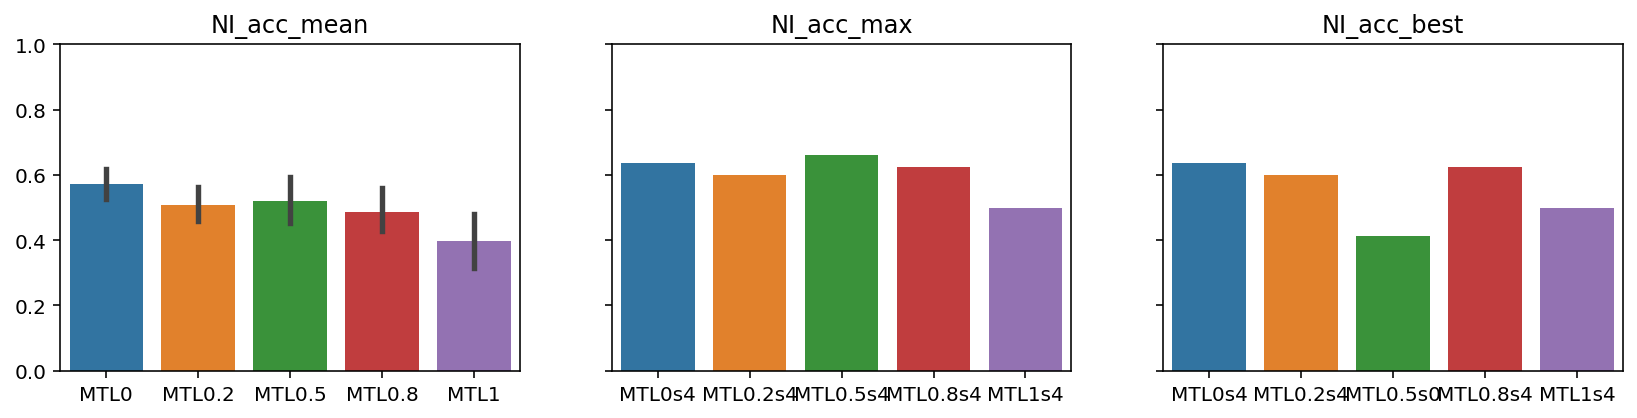

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
df = df_agent[id_columns + ['NI_acc']]
sns.barplot(ax=ax[0], data=df, x='model', y='NI_acc')
df = df_agent[id_columns + ['NI_acc']].loc[df_agent.groupby('model')['NI_acc'].idxmax()]
sns.barplot(ax=ax[1], data=df, x='name', y='NI_acc')
df = df_agent_best[id_columns + ['NI_acc']]
sns.barplot(ax=ax[2], data=df, x='name', y='NI_acc')
titles = ['NI_acc_mean', 'NI_acc_max', 'NI_acc_best']
_ = [(ax.set_ylim((0, 1)), ax.set(xlabel=None), ax.set(ylabel=None), ax.set_title(title)) for ax, title in zip(ax, titles)]
fig.savefig(f'plots/MTL0_d50/{project}.{group}/h2h_ni.pdf')

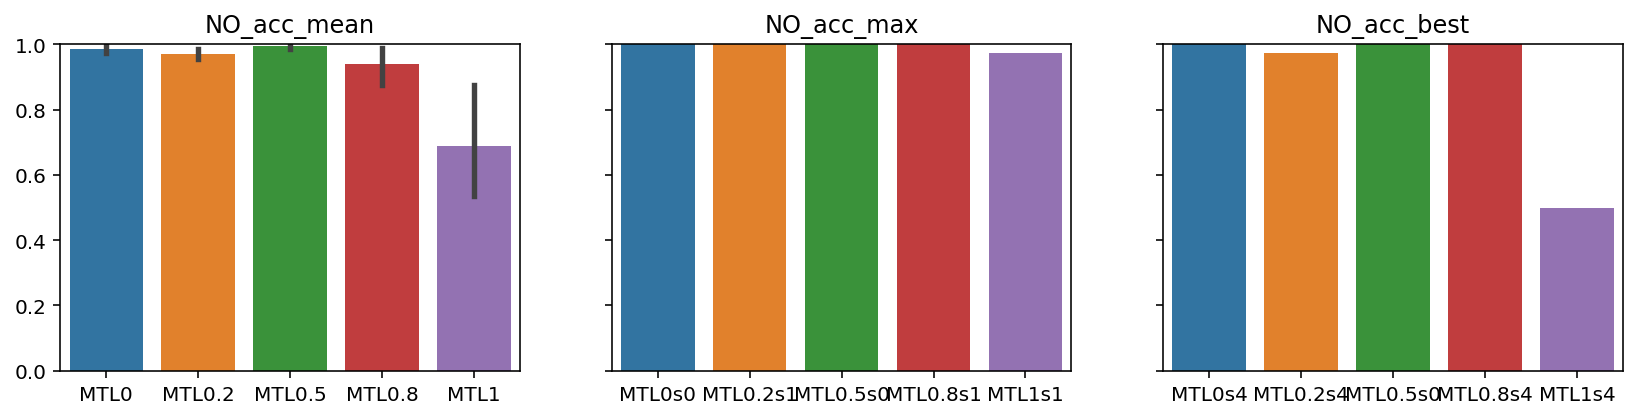

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
df = df_agent[id_columns + ['NO_acc']]
sns.barplot(ax=ax[0], data=df, x='model', y='NO_acc')
df = df_agent[id_columns + ['NO_acc']].loc[df_agent.groupby('model')['NO_acc'].idxmax()]
sns.barplot(ax=ax[1], data=df, x='name', y='NO_acc')
df = df_agent_best[id_columns + ['NO_acc']]
sns.barplot(ax=ax[2], data=df, x='name', y='NO_acc')
titles = ['NO_acc_mean', 'NO_acc_max', 'NO_acc_best']
_ = [(ax.set_ylim((0, 1)), ax.set(xlabel=None), ax.set(ylabel=None), ax.set_title(title)) for ax, title in zip(ax, titles)]
fig.savefig(f'plots/MTL0_d50/{project}.{group}/h2h_no.pdf')